# Starbucks Offers EDA

## Importing packages

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import data_preprocessing as dp
%matplotlib inline

## Reading and previewing the datasets

In [3]:
portfolio_df = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('../data/transcript.json', orient='records', lines=True)

In [4]:
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Data preprocessing

In [7]:
offers_delivered_df = dp.preprocess_offer_data(transcript_df, portfolio_df)
offers_delivered_df.head()

,person,event,value,time,offer_id,reward,channels,difficulty,duration,offer_type,id,offer_type_event,expiration_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_offer_received,7
1,a03223e636434f42ac4c3df47e8bac43,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_offer_received,10
2,e2127556f4f64592b11af22de27a7932,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount_offer_received,7
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_offer_received,10
4,68617ca6246f4fbc85e91a2a49552598,offer_received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_offer_received,5


## Analysis

### Offers Big Numbers and main conversion metrics

In [8]:
grouped_df = offers_delivered_df.groupby(['offer_type', 'event']).person.count().reset_index()
pivot_df = grouped_df.pivot(index='offer_type', columns='event', values='person')\
    .fillna(0).astype(int).reset_index()
pivot_df = pivot_df[['offer_type', 'offer_received', 'offer_viewed', 'offer_completed']]

pivot_df['view_rate'] = (pivot_df.offer_viewed/pivot_df.offer_received).round(2)
pivot_df['conversion_rate'] = (pivot_df.offer_completed/pivot_df.offer_viewed).round(2)
pivot_df['completion_rate'] = (pivot_df.offer_completed/pivot_df.offer_received).round(2)
pivot_df

event,offer_type,offer_received,offer_viewed,offer_completed,view_rate,conversion_rate,completion_rate
0,bogo,30499,25449,15669,0.83,0.62,0.51
1,discount,30543,21445,17910,0.70,0.84,0.59
2,informational,15235,10831,0,0.71,0.00,0.00


### Percentagem of customers who completed any offer per offer type

In [9]:
def get_best_offer_type(bogo, discount):
    """
    Function that evaluates if a customer completed
    more bogo than discout offers or neither of both.

    Args:
        bogo (int): Number of bogo offers completed
        discount (int): Number of discount offers completed

    Returns:
       string: offer type with more completions by a customer.
    """
    
    if bogo > discount:
        return 'bogo'

    if discount > bogo:
        return 'discount'

    if discount + bogo == 0:
        return 'none'
        
    return 'either'

In [10]:
offers_completed_df = dp.get_offer_completion_per_customer(offers_delivered_df)

offers_completed_df['best_offer_type'] = offers_completed_df.apply(
    lambda x: get_best_offer_type(x.bogo, x.discount), axis=1
)

offers_completed_df['bogo'] = (offers_completed_df['bogo']>0)*1
offers_completed_df['discount'] = (offers_completed_df['discount']>0)*1
offers_completed_df['completed_any_offer'] = \
    (offers_completed_df['bogo'] + offers_completed_df['discount']>0)*1

offers_completed_df[['bogo', 'discount', 'completed_any_offer']].mean(axis=0)

offer_type
bogo                   0.554604
discount               0.616034
completed_any_offer    0.764819
dtype: float64

In [11]:
offers_completed_df.best_offer_type.value_counts(normalize=True)

discount    0.351455
bogo        0.271943
none        0.235181
either      0.141420
Name: best_offer_type, dtype: float64

### Average Ticket per purchase and type of offer

In [12]:
transactions_per_offer_type_df = dp.get_customer_transactions_per_offer_type(
    transcript_df,
    offers_delivered_df
)

In [13]:
transactions_per_offer_type_df.offer_type.value_counts()

no_offer         127872
discount           5194
bogo               4634
informational      1255
Name: offer_type, dtype: int64

<AxesSubplot:xlabel='offer_type', ylabel='amount'>

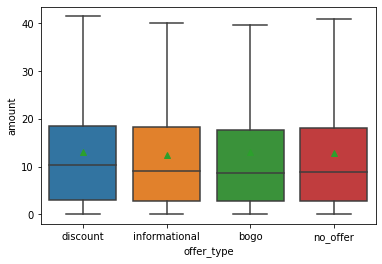

In [14]:
sns.boxplot(
    data=transactions_per_offer_type_df, 
    x="offer_type", y="amount", showfliers=False, showmeans=True
)

In [15]:
grouped_df = transactions_per_offer_type_df.groupby("offer_type")\
    .agg({"amount": [np.mean, np.min, np.median, np.max]})\
        .round(2).reset_index()

grouped_df.columns = grouped_df.columns.droplevel()
grouped_df.sort_values(by='median', ascending=False)

,,mean,amin,median,amax
1,discount,13.04,0.05,10.38,989.34
2,informational,12.36,0.05,9.05,552.43
3,no_offer,12.76,0.05,8.83,1062.28
0,bogo,13.00,0.05,8.61,871.51


### Offer usage by age group

In [16]:
def get_age_group(age):
    """
    Function that return the age group of
    a customer

    Args:
        age (int): Age of the customer

    Returns:
        string: Age group of the customer.
    """
    if age < 15:
        return 'child'
    
    if age < 25:
        return 'youth'
    
    if age < 65:
        return 'adult'
    
    return 'senior'

In [17]:
df = transactions_per_offer_type_df.merge(profile_df, left_on='person', right_on='id')
df['age_group'] = df.age.apply(get_age_group)

In [18]:
df.age_group.value_counts(normalize=True)

adult     0.589126
senior    0.346616
youth     0.064258
Name: age_group, dtype: float64

<AxesSubplot:ylabel='Frequency'>

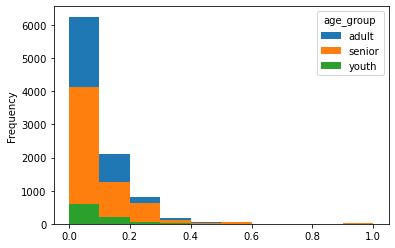

In [19]:
grouped_df = df.groupby(['person', 'age_group']).is_offer.mean().reset_index()
grouped_df.pivot(columns='age_group', values='is_offer').plot.hist(bins=10)

### Customers who spend more with than without offers viewed

In [20]:

grouped_df = transactions_per_offer_type_df.groupby(['person', 'is_offer']).amount.mean().reset_index()
pivot_df = grouped_df.pivot(index='person', columns='is_offer', values='amount').fillna(0).round(2).reset_index()
pivot_df = pivot_df.rename(columns={0:'avg_amount_without_offer', 1:'avg_amount_with_offer'})
pivot_df['spent_more_with_offers'] = pivot_df['avg_amount_with_offer'] > pivot_df['avg_amount_without_offer']
pivot_df.tail()

is_offer,person,avg_amount_without_offer,avg_amount_with_offer,spent_more_with_offers
16573,fff3ba4757bd42088c044ca26d73817a,19.09,204.60,True
16574,fff7576017104bcc8677a8d63322b5e1,4.99,0.00,False
16575,fff8957ea8b240a6b5e634b6ee8eafcf,2.43,0.00,False
16576,fffad4f4828548d1b5583907f2e9906b,7.40,0.00,False
16577,ffff82501cea40309d5fdd7edcca4a07,14.89,17.55,True


In [21]:
pivot_df.spent_more_with_offers.value_counts(normalize=True)

False    0.799493
True     0.200507
Name: spent_more_with_offers, dtype: float64